In [21]:
import seaborn as sns
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random

dataset = load_dataset('bigscience/P3', 'ai2_arc_ARC_Challenge_pick_the_most_correct_option')

In [22]:
for ix ,i in enumerate(dataset['train']):
    print('pretokenized inputs: ', i['inputs_pretokenized'])
    print('pretokenized targets: ', i['targets_pretokenized'], '\n')

pretokenized inputs:  Pick the most correct option to answer the following question.

George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?

Options:

- A: dry palms

- B: wet palms

- C: palms covered with oil

- D: palms covered with lotion
 
pretokenized targets:  
A 

pretokenized inputs:  Pick the most correct option to answer the following question.

Which of the following statements best explains why magnets usually stick to a refrigerator door?

Options:

- A: The refrigerator door is smooth.

- B: The refrigerator door contains iron.

- C: The refrigerator door is a good conductor.

- D: The refrigerator door has electric wires in it.
 
pretokenized targets:  
B 

pretokenized inputs:  Pick the most correct option to answer the following question.

A fold observed in layers of sedimentary rock most likely resulted from the

Options:

- A: cooling of flowing magma.

- B: converging of crustal plates.

- C: deposition of river sed

In [37]:
# Load the dataset
dataset = load_dataset('bigscience/P3', 'ai2_arc_ARC_Challenge_pick_the_most_correct_option')
train_dataset = dataset['train']

# Initialize the tokenizer and models (one or continuous prompting and other for projected prompting
model_projected = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_projected.to(device)

# Define the prompt basis
prompt_list = [
    "Generate a flowchart to visually represent the logic needed to answer the question",
    "Write pseudocode for an algorithm that could determine the answer", 
    "Imagine you are explaining the answer to a 5-year-old. Use simple words and analogies.",
    "Summarize the key insights needed to answer in a short poem",
    "Draw a concept map connecting all ideas relevant to the question",
    "List assumptions you must make to provide an answer. What if those assumptions were different?",
    "Compare and contrast multiple ways to approach the question", 
    "Translate the essence of the question into visual art and describe your interpretation",
    "Act out an exaggerated skit to depict the logic behind the answer",
    "Design a decision tree leading to the final answer",
    "Develop a graphic organizer highlighting relationships between key ideas",
    "Frame the question from different philosophical perspectives and give each perspective's answer", 
    "Outline an experiment that could empirically validate the answer",
    "Write a song conveying the concepts needed to respond accurately",
    "Create a metaphor relating the question to a seemingly unrelated domain",
    "Prototype a computer program to compute the answer algorithmically"
]

print(f'tokenizing prompts')
print(f'prompt list length {len(prompt_list)}')

basis = tokenizer(prompt_list, padding=True, truncation=True, return_tensors='pt').to(device)
basis = model_projected.model.shared(basis.input_ids)

def tokenize_function(example):
    return tokenizer(example['inputs_pretokenized'], truncation=True, padding='max_length')

# Apply the function to the dataset
print('tokenzing dataset')
dataset = dataset.map(tokenize_function, batched=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the weight prediction model
class LearnWeights(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.15):
        super(LearnWeights, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(512, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        batch_size, seq_length, feature_size = x.size()
        x = x.view(batch_size * seq_length, -1)  # Flatten the tensor along the sequence length and feature size dimensions
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.output_layer(x)
        x = x.view(batch_size, seq_length, -1)  # Reshape the tensor back to (batch_size, seq_length, output_dim)
        x = x.mean(dim=1, keepdim=True)  # Compute the mean across the token dimension
        return x.squeeze(1).mean(dim=0)


# Define the projected prompt
input_dim = 1024

output_dim = len(prompt_list)
learn_weights = LearnWeights(input_dim, output_dim).to(device)
optimizer_projected = torch.optim.AdamW(learn_weights.parameters())

# Training parameters
epochs = 50
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizing prompts
prompt list length 16
tokenzing dataset


Training...
Validating Epoch...
Epoch Validation Loss: 11.551407066551414 

Saveing figure...


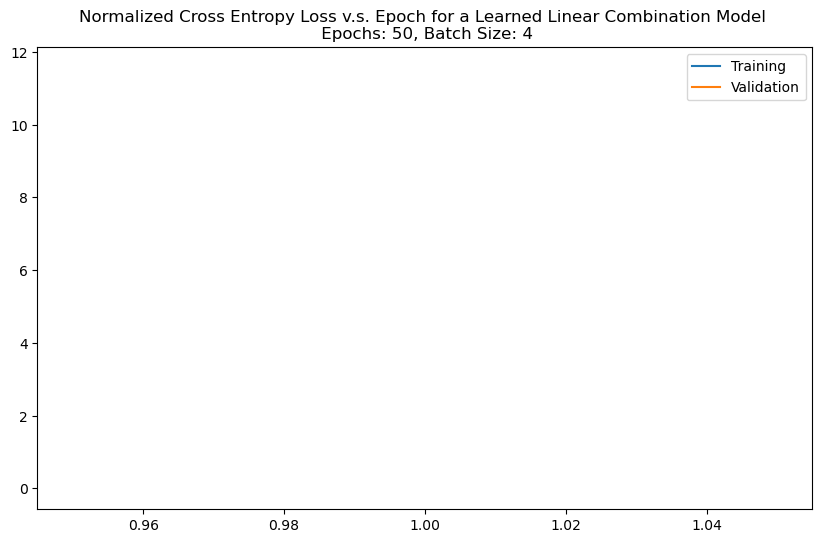

Validating Epoch...


KeyboardInterrupt: 

In [40]:
print('Training...')

# Training loop
projected_losses = []
validation_losses = []

shapes = []


for epoch in range(epochs):
    epoch_loss_projected = 0
    epoch_loss_validation = 0
    for _ in range(0, len(train_dataset) - 9700, batch_size):
        i = random.randint(0, len(train_dataset) - batch_size + 1 )
        batch = train_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 150 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)

        print(f'input embeddings shape' + str(input_embeddings.shape))
        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')
        
        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)
        padding_size = max(0, 250 - combined_projected_embeddings.shape[1])
        combined_projected_embeddings = F.pad(combined_projected_embeddings, (0, 0, 0, padding_size), "constant", 0)
        print(f'combined projected embeddings shape' + str(combined_projected_embeddings.shape))

        # Pass the combined embeddings through the model
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)
 

        loss_projected = outputs_projected.loss
        epoch_loss_projected += loss_projected.item()
        

        optimizer_projected.zero_grad()
        loss_projected.backward(retain_graph=True)
        optimizer_projected.step()

        #print(f'complete from this epoch {i}/{len(train_dataset)}', end='')
        if _ % 200 == 0:
          print(f'Epoch {epoch+1}/{epochs}, Batch {_}/{len(train_dataset)}')
          print(f'Batch Indices: {[i + k for k in range(i, i+batch_size)]}')
          print(f'Loss: {loss_projected.item()}')
          print()

    print('Validating Epoch...')

    for _ in range(0, len(validation_dataset), batch_size):
        i = random.randint(0, len(validation_dataset) - batch_size + 1 )
        batch = validation_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 150 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')

        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)
        padding_size = max(0, 250 - combined_projected_embeddings.shape[1])
        combined_projected_embeddings = F.pad(combined_projected_embeddings, (0, 0, 0, padding_size), "constant", 0)
        #print(f'combined projected embeddings shape' + str(combined_projected_embeddings.shape))
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)
        
        

        loss_validation = outputs_projected.loss
        epoch_loss_validation += loss_validation.item()

    epoch_loss_projected /= (len(list(range(0, len(train_dataset), batch_size))))
    epoch_loss_validation /= (len(list(range(0, len(validation_dataset), batch_size))) - 1)

    print(f'Epoch Validation Loss: {epoch_loss_validation} \n', end='')
    print()

    projected_losses.append(epoch_loss_projected)
    validation_losses.append(epoch_loss_validation)

    # Create a DataFrame with the loss values
    n = len(projected_losses)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n + 1), projected_losses, label='Training')
    plt.plot(range(1, n + 1), validation_losses, label='Validation')
    
    plt.title(f'Normalized Cross Entropy Loss v.s. Epoch for a Learned Linear Combination Model \n Epochs: {epochs}, Batch Size: {batch_size}')
    plt.legend()

    # Save the plot as a png file
    print(f'Saveing figure...')
    plt.savefig(f'loss_plot_epoch_{epoch+1}.png')
    plt.show()